## Imports & Setup

In [1]:
# Cell 1 – Imports & Setup
import numpy as np
import matplotlib.pyplot as plt
import os
from math import pi

np.random.seed(42)

# Plot directory
plot_dir = "plots_sigma2I"
os.makedirs(plot_dir, exist_ok=True)


## Load Data

In [2]:
#Cell 2 – Load Data

# Change paths if files are stored elsewhere
file1 = "LS_Group15/LS_Group15_Class1.txt"
file2 = "LS_Group15/LS_Group15_Class2.txt"
file3 = "LS_Group15/LS_Group15_Class3.txt"

X1 = np.loadtxt(file1)
X2 = np.loadtxt(file2)
X3 = np.loadtxt(file3)

classes_data = {1: X1, 2: X2, 3: X3}
n_classes = len(classes_data)

print("Loaded dataset shapes:")
for k, X in classes_data.items():
    print(f"Class {k}: {X.shape}")


Loaded dataset shapes:
Class 1: (500, 2)
Class 2: (500, 2)
Class 3: (500, 2)


## Train/Test Split (70/30 per class)

In [3]:
# Cell 3 – Train/Test Split (70/30 per class)

train_data, test_data = {}, {}
for k, X in classes_data.items():
    n = X.shape[0]
    perm = np.random.permutation(n)
    split = int(0.7 * n)
    train_data[k] = X[perm[:split]]
    test_data[k] = X[perm[split:]]


## Estimate Means & Shared σ²

In [4]:
# Cell 4 – Estimate Means & Shared σ²

means = {}
variances = []
for k in range(1, n_classes+1):
    mu = train_data[k].mean(axis=0)
    cov = np.cov(train_data[k], rowvar=False, bias=False)
    means[k] = mu
    variances.extend(np.diag(cov))  # collect variances from diagonal

sigma2 = np.mean(variances)              # average variance
Sigma_sigma2I = sigma2 * np.eye(2)       # σ² I
print("Estimated σ²:", sigma2)


Estimated σ²: 5.054216186189922


## Gaussian log-pdf (σ²I case)

In [5]:
# Cell 5 – Gaussian log-pdf (σ²I case)

def log_mvnpdf_constI(X, mu, sigma2):
    """
    Log pdf of Gaussian with covariance = sigma² I
    X: (n_samples, d)
    mu: (d,)
    """
    X = np.atleast_2d(X)
    d = mu.shape[0]
    diff = X - mu
    exponent = -0.5 * (1.0 / sigma2) * np.sum(diff * diff, axis=1)
    const = -0.5 * (d * np.log(2 * pi) + d * np.log(sigma2))
    return const + exponent


## Priors & Predictor

In [6]:
# Cell 6 – Priors & Predictor

# Priors from training proportions
total_train = sum(train_data[k].shape[0] for k in train_data)
priors = {k: train_data[k].shape[0] / total_train for k in train_data}

def predict_sigma2I(X):
    """Predict class labels using means, σ² I, and priors"""
    X = np.atleast_2d(X)
    logpost = np.full((X.shape[0], n_classes), -np.inf)
    for i, k in enumerate(sorted(means.keys())):
        log_lik = log_mvnpdf_constI(X, means[k], sigma2)
        logpost[:, i] = log_lik + np.log(priors[k])
    preds_idx = np.argmax(logpost, axis=1)
    return np.array([sorted(means.keys())[i] for i in preds_idx])



## Meshgrid for Plotting

In [7]:
# Cell 7 – Meshgrid for Plotting

all_train = np.vstack([train_data[k] for k in train_data])
margin = 1.0
xmin, xmax = all_train[:,0].min() - margin, all_train[:,0].max() + margin
ymin, ymax = all_train[:,1].min() - margin, all_train[:,1].max() + margin

xx, yy = np.meshgrid(np.linspace(xmin, xmax, 500),
                     np.linspace(ymin, ymax, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]



## Decision Region (All Classes)

C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


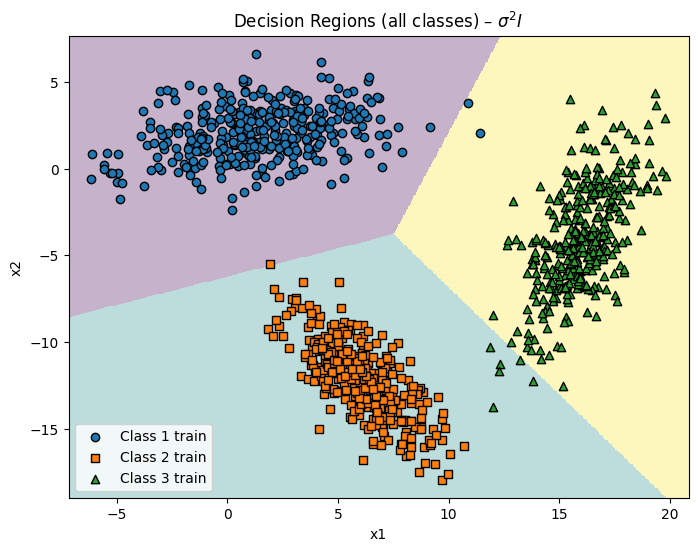

In [8]:
# Cell 8 – Decision Region (All Classes)

Z_all = predict_sigma2I(grid_points).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.pcolormesh(xx, yy, Z_all, shading='auto', alpha=0.3)

markers = {1:'o', 2:'s', 3:'^'}
for k in sorted(train_data.keys()):
    plt.scatter(train_data[k][:,0], train_data[k][:,1],
                label=f"Class {k} train", marker=markers[k], edgecolor='k')

plt.title(r"Decision Regions (all classes) – $\sigma^2 I$")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()



## Pairwise Decision Regions

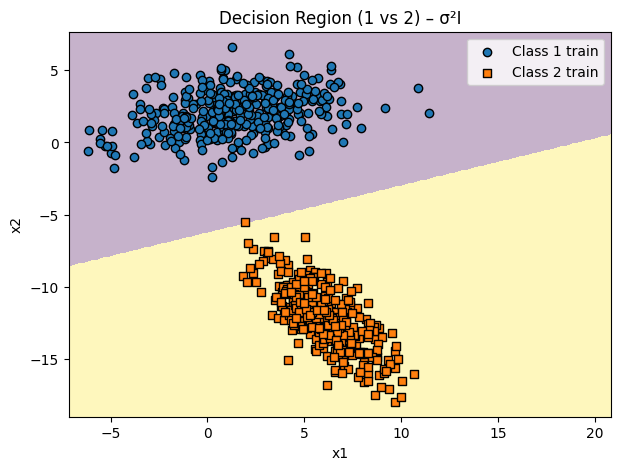

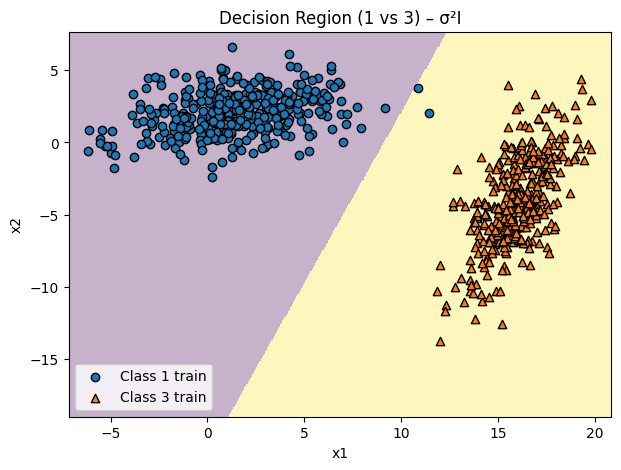

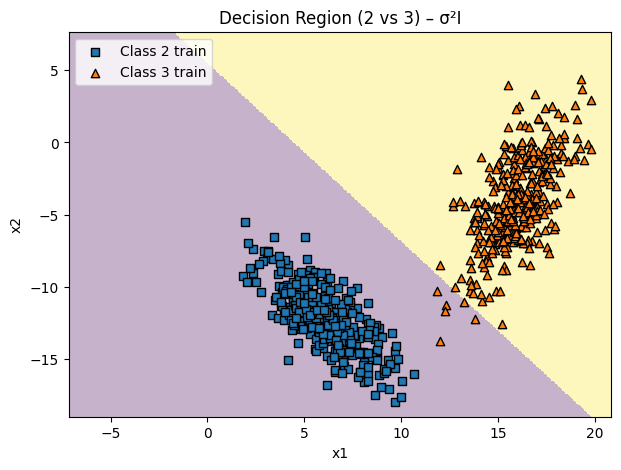

In [9]:
# Cell 9 – Pairwise Decision Regions

pairs = [(1,2),(1,3),(2,3)]

def predict_pair(X, a, b):
    X = np.atleast_2d(X)
    logpost = np.full((X.shape[0], 2), -np.inf)
    prior_sum = priors[a] + priors[b]
    for i, k in enumerate([a,b]):
        log_lik = log_mvnpdf_constI(X, means[k], sigma2)
        log_prior = np.log(priors[k] / prior_sum)
        logpost[:, i] = log_lik + log_prior
    preds = np.array([a,b])[np.argmax(logpost, axis=1)]
    return preds

for a,b in pairs:
    Z_pair = predict_pair(grid_points, a, b).reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z_pair, shading='auto', alpha=0.3)
    plt.scatter(train_data[a][:,0], train_data[a][:,1], label=f"Class {a} train",
                marker=markers[a], edgecolor='k')
    plt.scatter(train_data[b][:,0], train_data[b][:,1], label=f"Class {b} train",
                marker=markers[b], edgecolor='k')
    plt.title(f"Decision Region ({a} vs {b}) – σ²I")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()


## Evaluate Classifier (σ² I) on Test Data

In [10]:
# Cell 10 – Evaluate Classifier (σ² I) on Test Data

from sklearn.metrics import confusion_matrix

# Collect test data & labels
X_test = np.vstack([test_data[k] for k in test_data])
y_test = np.concatenate([[k]*len(test_data[k]) for k in test_data])

# Predict using σ² I classifier
y_pred = predict_sigma2I(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3])
acc = np.trace(cm) / np.sum(cm)

print("Confusion Matrix (σ² I):")
print(cm)
print("\nAccuracy:", acc)


Confusion Matrix (σ² I):
[[150   0   0]
 [  0 150   0]
 [  0   1 149]]

Accuracy: 0.9977777777777778


## Precision, Recall, F1

In [11]:
# Cell 11 – Precision, Recall, F1

def compute_metrics(cm):
    n_classes = cm.shape[0]
    precision, recall, f1 = [], [], []
    for i in range(n_classes):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
        precision.append(prec)
        recall.append(rec)
        f1.append(f)
    return precision, recall, f1

precision, recall, f1 = compute_metrics(cm)

print("Per-Class Metrics (σ² I):")
for i,(p,r,f) in enumerate(zip(precision, recall, f1), start=1):
    print(f"Class {i}: Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")

print("\nMean Precision:", np.mean(precision))
print("Mean Recall:", np.mean(recall))
print("Mean F1:", np.mean(f1))


Per-Class Metrics (σ² I):
Class 1: Precision=1.000, Recall=1.000, F1=1.000
Class 2: Precision=0.993, Recall=1.000, F1=0.997
Class 3: Precision=1.000, Recall=0.993, F1=0.997

Mean Precision: 0.9977924944812363
Mean Recall: 0.9977777777777778
Mean F1: 0.9977777530861452


## Inference / Observations

In [12]:
# Cell 12 – Inference / Observations

print("Inference for σ² I decision regions:")

if acc > 0.95:
    print("- The classifier achieves very high accuracy, close to perfect separation.")
else:
    print("- The classifier accuracy is moderate; decision boundaries may not capture the classes well.")

print("- Since σ² I assumes identical spherical covariance for all classes, "
      "decision boundaries are linear and roughly equidistant between class means.")

print("- The plots show that boundaries are straight lines separating the class clusters.")
print("- Because the dataset is linearly separable, σ² I is sufficient to nearly perfectly classify the data.")


Inference for σ² I decision regions:
- The classifier achieves very high accuracy, close to perfect separation.
- Since σ² I assumes identical spherical covariance for all classes, decision boundaries are linear and roughly equidistant between class means.
- The plots show that boundaries are straight lines separating the class clusters.
- Because the dataset is linearly separable, σ² I is sufficient to nearly perfectly classify the data.


## Contour Plot (σ²I, all classes together)

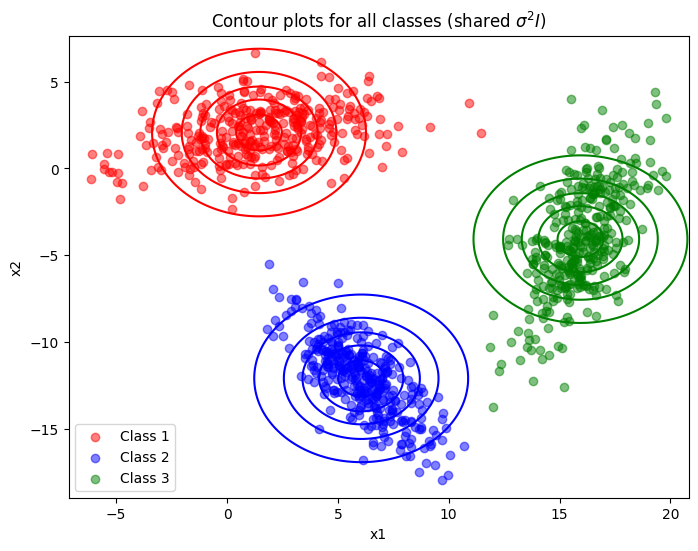

In [13]:
# Cell 13 – Contour Plot (σ²I, all classes together)
# Contour plot using σ²I for all classes together
levels = [0.1, 0.3, 0.5, 0.7, 0.9]  # relative contour levels

plt.figure(figsize=(8,6))
colors = {1:"red", 2:"blue", 3:"green"}

for k in means:
    # compute pdf over grid
    logpdf = log_mvnpdf_constI(grid_points, means[k], sigma2)
    pdf = np.exp(logpdf - np.max(logpdf))  # normalize for display
    ZZ = pdf.reshape(xx.shape)

    # draw contours
    plt.contour(xx, yy, ZZ, levels=levels, colors=colors[k])
    # overlay training points
    plt.scatter(train_data[k][:,0], train_data[k][:,1], c=colors[k], label=f"Class {k}", alpha=0.5)

plt.title(r"Contour plots for all classes (shared $\sigma^2 I$)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


## Contour Plots with Each Class’s Own σ²I

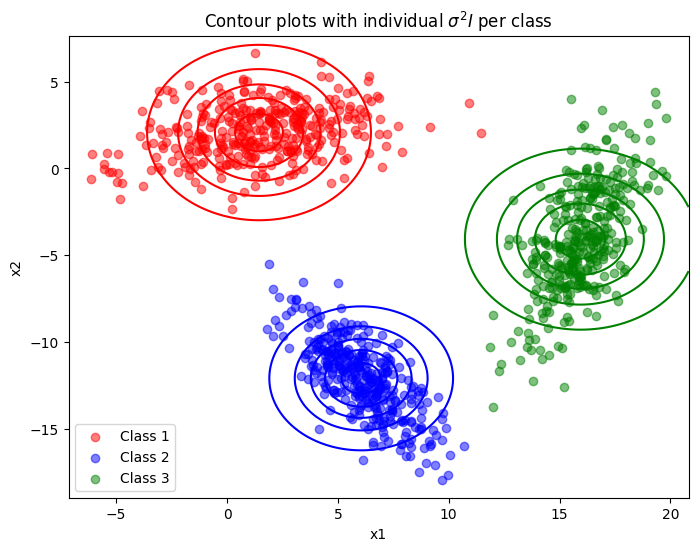

In [14]:
'''
Cell 14 – Contour Plots with Each Class’s Own σ²I

Here, instead of using the shared σ², we compute each class’s individual variance (average of its covariance diagonal) and use it for its contours.

'''

plt.figure(figsize=(8,6))
for k in means:
    # compute σ² for this class only
    cov_k = np.cov(train_data[k], rowvar=False, bias=False)
    sigma2_k = np.mean(np.diag(cov_k))

    logpdf = log_mvnpdf_constI(grid_points, means[k], sigma2_k)
    pdf = np.exp(logpdf - np.max(logpdf))
    ZZ = pdf.reshape(xx.shape)

    plt.contour(xx, yy, ZZ, levels=levels, colors=colors[k])
    plt.scatter(train_data[k][:,0], train_data[k][:,1], c=colors[k], label=f"Class {k}", alpha=0.5)

plt.title(r"Contour plots with individual $\sigma^2 I$ per class")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()



## Covariance Matrices (Per-Class, Average, Shared σ²I)

In [15]:
# Cell 15 – Covariance Matrices (Per-Class, Average, Shared σ²I)

# Compute covariance matrices
cov_per_class = {k: np.cov(train_data[k], rowvar=False, bias=False) for k in train_data}

print("Individual covariance matrices:")
for k, cov in cov_per_class.items():
    print(f"\nClass {k} covariance:\n{cov}")

# Average covariance matrix (elementwise)
avg_cov = sum(cov_per_class.values()) / len(cov_per_class)
print("\nAverage covariance matrix (Σ_avg):\n", avg_cov)

# Shared covariance σ²I
print("\nShared covariance σ²I:\n", Sigma_sigma2I)



Individual covariance matrices:

Class 1 covariance:
[[8.80157416 1.35490333]
 [1.35490333 2.27040313]]

Class 2 covariance:
[[ 2.79758295 -2.66056384]
 [-2.66056384  4.65994096]]

Class 3 covariance:
[[2.09518912 2.76726304]
 [2.76726304 9.7006068 ]]

Average covariance matrix (Σ_avg):
 [[4.56478207 0.48720084]
 [0.48720084 5.5436503 ]]

Shared covariance σ²I:
 [[5.05421619 0.        ]
 [0.         5.05421619]]


## Compute Common Full Covariance Σ

In [16]:
# Cell 16 – Compute Common Full Covariance Σ
# Compute per-class covariance matrices
cov_per_class = {k: np.cov(train_data[k], rowvar=False, bias=False) for k in train_data}

# Average covariance matrix (Σ_avg)
Sigma_common = sum(cov_per_class.values()) / len(cov_per_class)
print("Common full covariance Σ:\n", Sigma_common)



Common full covariance Σ:
 [[4.56478207 0.48720084]
 [0.48720084 5.5436503 ]]


## Gaussian log-pdf (general Σ)

In [17]:
# Cell 17 – Gaussian log-pdf (general Σ)

def log_mvnpdf_general(X, mu, Sigma):
    """Log pdf for general covariance matrix Σ"""
    X = np.atleast_2d(X)
    d = mu.shape[0]
    sign, logdet = np.linalg.slogdet(Sigma)
    invSigma = np.linalg.inv(Sigma)
    diff = X - mu
    exponent = -0.5 * np.sum(diff @ invSigma * diff, axis=1)
    const = -0.5 * (d * np.log(2 * np.pi) + logdet)
    return const + exponent


## Predictor with Common Σ

In [18]:
# Cell 18 – Predictor with Common Σ

def predict_commonSigma(X):
    X = np.atleast_2d(X)
    logpost = np.full((X.shape[0], n_classes), -np.inf)
    for i, k in enumerate(sorted(means.keys())):
        log_lik = log_mvnpdf_general(X, means[k], Sigma_common)
        logpost[:, i] = log_lik + np.log(priors[k])
    preds_idx = np.argmax(logpost, axis=1)
    return np.array([sorted(means.keys())[i] for i in preds_idx])


## Decision Region (All Classes, Common Σ)

C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


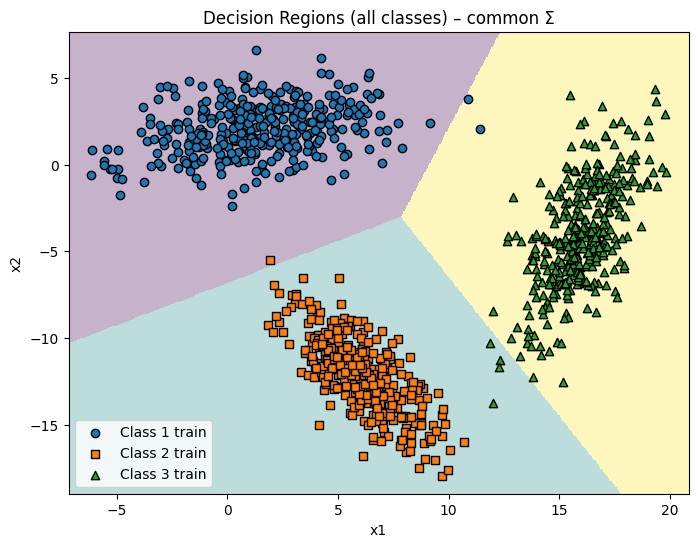

In [19]:
# Cell 19 – Decision Region (All Classes, Common Σ)

Z_all_common = predict_commonSigma(grid_points).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.pcolormesh(xx, yy, Z_all_common, shading='auto', alpha=0.3)

for k in sorted(train_data.keys()):
    plt.scatter(train_data[k][:,0], train_data[k][:,1],
                label=f"Class {k} train", marker=markers[k], edgecolor='k')

plt.title("Decision Regions (all classes) – common Σ")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


## Pairwise Decision Regions (Common Σ)

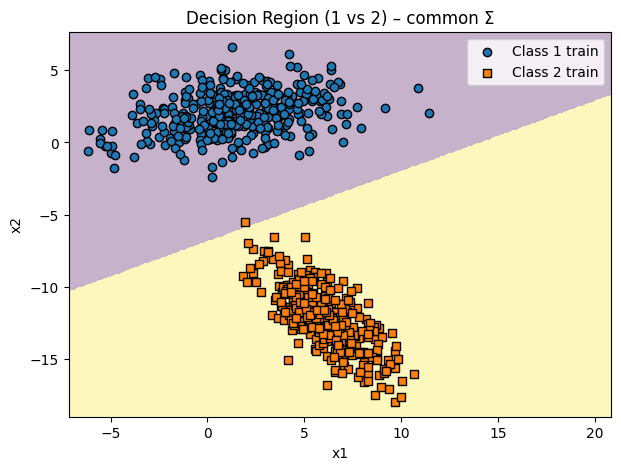

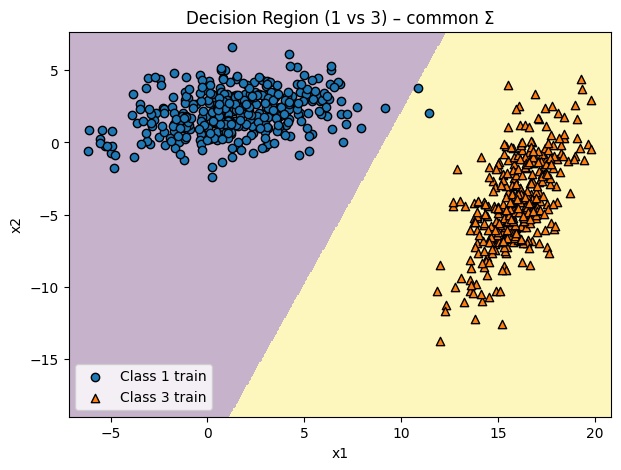

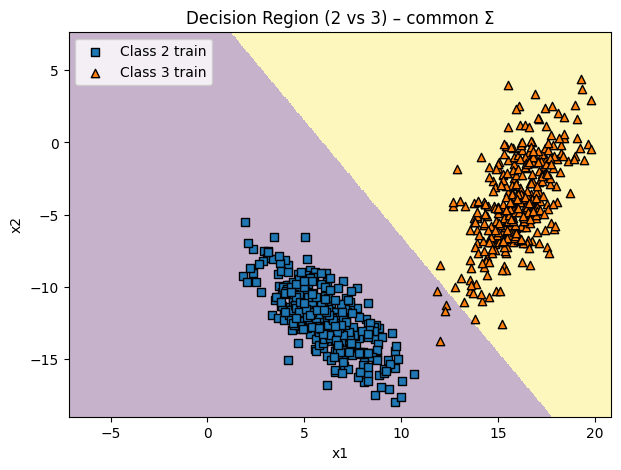

In [20]:
# Cell 20 – Pairwise Decision Regions (Common Σ)

pairs = [(1,2), (1,3), (2,3)]

def predict_pair_commonSigma(X, a, b):
    X = np.atleast_2d(X)
    logpost = np.full((X.shape[0], 2), -np.inf)
    prior_sum = priors[a] + priors[b]
    for i, k in enumerate([a,b]):
        log_lik = log_mvnpdf_general(X, means[k], Sigma_common)
        log_prior = np.log(priors[k] / prior_sum)
        logpost[:, i] = log_lik + log_prior
    preds = np.array([a,b])[np.argmax(logpost, axis=1)]
    return preds

for a,b in pairs:
    Z_pair = predict_pair_commonSigma(grid_points, a, b).reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z_pair, shading='auto', alpha=0.3)
    plt.scatter(train_data[a][:,0], train_data[a][:,1], label=f"Class {a} train",
                marker=markers[a], edgecolor='k')
    plt.scatter(train_data[b][:,0], train_data[b][:,1], label=f"Class {b} train",
                marker=markers[b], edgecolor='k')
    plt.title(f"Decision Region ({a} vs {b}) – common Σ")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()



## Inference for Decision Regions with Σ

In [21]:
# Cell 21 – Inference for Decision Regions with Σ

# Evaluate performance
y_pred_common = predict_commonSigma(X_test)
cm_common = confusion_matrix(y_test, y_pred_common, labels=[1,2,3])
acc_common = np.trace(cm_common) / np.sum(cm_common)

print("Confusion Matrix (common Σ):")
print(cm_common)
print("\nAccuracy:", acc_common)

# Simple inference text
print("\nInference for common Σ:")
if acc_common > 0.95:
    print("- The classifier achieves near-perfect accuracy.")
else:
    print("- The classifier accuracy is lower than σ²I, suggesting Σ captures class spread differently.")

print("- Decision boundaries are still linear, but unlike σ²I, "
      "they are oriented according to the average covariance shape.")
print("- Since the dataset is linearly separable, using Σ maintains very high classification performance.")


Confusion Matrix (common Σ):
[[150   0   0]
 [  0 150   0]
 [  0   1 149]]

Accuracy: 0.9977777777777778

Inference for common Σ:
- The classifier achieves near-perfect accuracy.
- Decision boundaries are still linear, but unlike σ²I, they are oriented according to the average covariance shape.
- Since the dataset is linearly separable, using Σ maintains very high classification performance.


## Contour Plot (Shared Σ, all classes together)

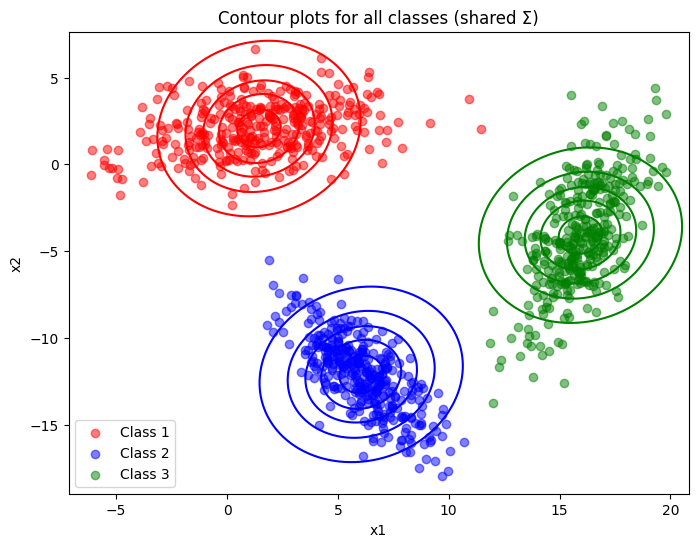

In [22]:
# Cell 22 – Contour Plot (Shared Σ, all classes together)

# Contour plot using the shared Σ for all classes
levels = [0.1, 0.3, 0.5, 0.7, 0.9]  # relative contour levels

plt.figure(figsize=(8,6))
colors = {1:"red", 2:"blue", 3:"green"}

for k in means:
    # pdf on grid using shared Σ
    logpdf = log_mvnpdf_general(grid_points, means[k], Sigma_common)
    pdf = np.exp(logpdf - np.max(logpdf))  # normalize for plotting
    ZZ = pdf.reshape(xx.shape)

    # draw contours
    plt.contour(xx, yy, ZZ, levels=levels, colors=colors[k])
    # overlay training points
    plt.scatter(train_data[k][:,0], train_data[k][:,1], c=colors[k], label=f"Class {k}", alpha=0.5)

plt.title("Contour plots for all classes (shared Σ)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


##  Contour Plots (Each Class vs Shared Σ)

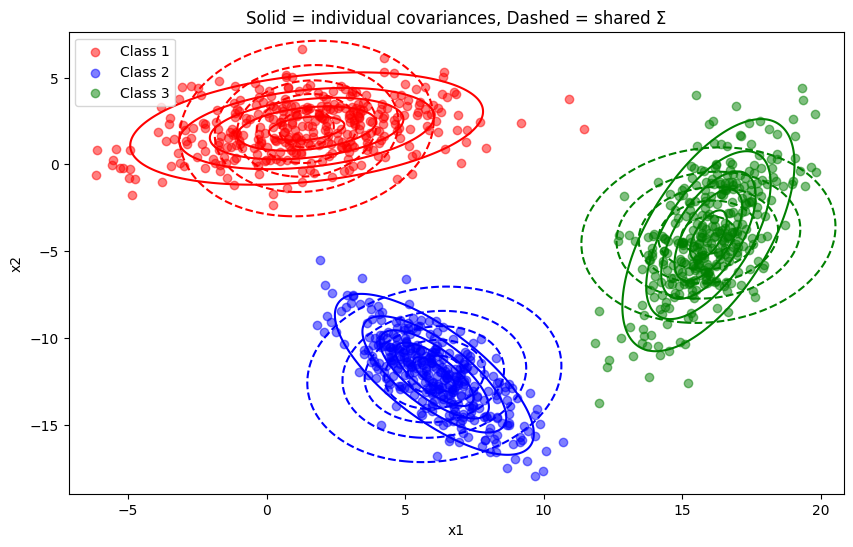

In [23]:
'''

Cell 23 – Contour Plots (Each Class vs Shared Σ)

Here we compare the true covariance contours of each class vs the shared Σ contours for the same class mean.

'''

plt.figure(figsize=(10,6))

for k in means:
    mu = means[k]

    # Class-specific covariance
    cov_k = cov_per_class[k]
    logpdf_class = log_mvnpdf_general(grid_points, mu, cov_k)
    pdf_class = np.exp(logpdf_class - np.max(logpdf_class))
    ZZ_class = pdf_class.reshape(xx.shape)

    # Shared Σ covariance
    logpdf_shared = log_mvnpdf_general(grid_points, mu, Sigma_common)
    pdf_shared = np.exp(logpdf_shared - np.max(logpdf_shared))
    ZZ_shared = pdf_shared.reshape(xx.shape)

    # Plot both
    plt.contour(xx, yy, ZZ_class, levels=levels, colors=colors[k], linestyles="solid")
    plt.contour(xx, yy, ZZ_shared, levels=levels, colors=colors[k], linestyles="dashed")

    # Overlay training points
    plt.scatter(train_data[k][:,0], train_data[k][:,1], c=colors[k], alpha=0.5, label=f"Class {k}")

plt.title("Solid = individual covariances, Dashed = shared Σ")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


## Covariance Matrices (Individual & Shared Σ)

In [24]:
# Cell 24 – Covariance Matrices (Individual & Shared Σ)

print("Individual covariance matrices (Σ_k):")
for k, cov in cov_per_class.items():
    print(f"\nClass {k}:\n{cov}")

print("\nShared covariance matrix (Σ):")
print(Sigma_common)


Individual covariance matrices (Σ_k):

Class 1:
[[8.80157416 1.35490333]
 [1.35490333 2.27040313]]

Class 2:
[[ 2.79758295 -2.66056384]
 [-2.66056384  4.65994096]]

Class 3:
[[2.09518912 2.76726304]
 [2.76726304 9.7006068 ]]

Shared covariance matrix (Σ):
[[4.56478207 0.48720084]
 [0.48720084 5.5436503 ]]


##  Build Diagonal Covariance Matrices (Σᵢ)

In [25]:
# Cell 25 – Build Diagonal Covariance Matrices (Σᵢ)

# Diagonal covariance for each class
cov_diag_per_class = {k: np.diag(np.diag(cov_per_class[k])) for k in cov_per_class}

print("Diagonal covariance matrices Σ_i for each class:")
for k, covd in cov_diag_per_class.items():
    print(f"\nClass {k} Σ_i (diagonal):\n{covd}")


Diagonal covariance matrices Σ_i for each class:

Class 1 Σ_i (diagonal):
[[8.80157416 0.        ]
 [0.         2.27040313]]

Class 2 Σ_i (diagonal):
[[2.79758295 0.        ]
 [0.         4.65994096]]

Class 3 Σ_i (diagonal):
[[2.09518912 0.        ]
 [0.         9.7006068 ]]


##  Predictor with Diagonal Σᵢ

In [26]:
# Cell 26 – Predictor with Diagonal Σᵢ

def predict_diagSigma(X):
    X = np.atleast_2d(X)
    logpost = np.full((X.shape[0], n_classes), -np.inf)
    for i, k in enumerate(sorted(means.keys())):
        log_lik = log_mvnpdf_general(X, means[k], cov_diag_per_class[k])
        logpost[:, i] = log_lik + np.log(priors[k])
    preds_idx = np.argmax(logpost, axis=1)
    return np.array([sorted(means.keys())[i] for i in preds_idx])


## Decision Region (All Classes, Diagonal Σᵢ)

C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


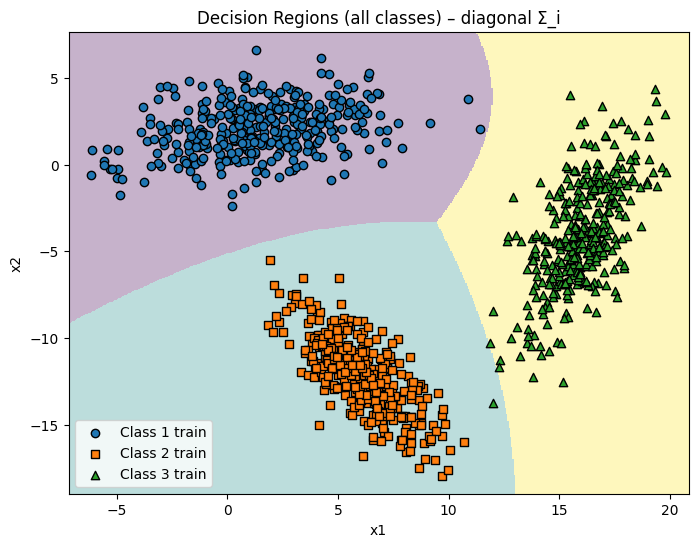

In [27]:
# Cell 27 – Decision Region (All Classes, Diagonal Σᵢ)

Z_all_diag = predict_diagSigma(grid_points).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.pcolormesh(xx, yy, Z_all_diag, shading='auto', alpha=0.3)

for k in sorted(train_data.keys()):
    plt.scatter(train_data[k][:,0], train_data[k][:,1],
                label=f"Class {k} train", marker=markers[k], edgecolor='k')

plt.title("Decision Regions (all classes) – diagonal Σ_i")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


## Pairwise Decision Regions (Diagonal Σᵢ)

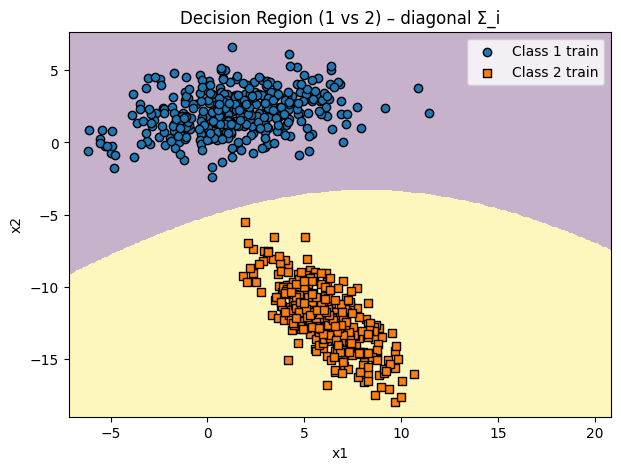

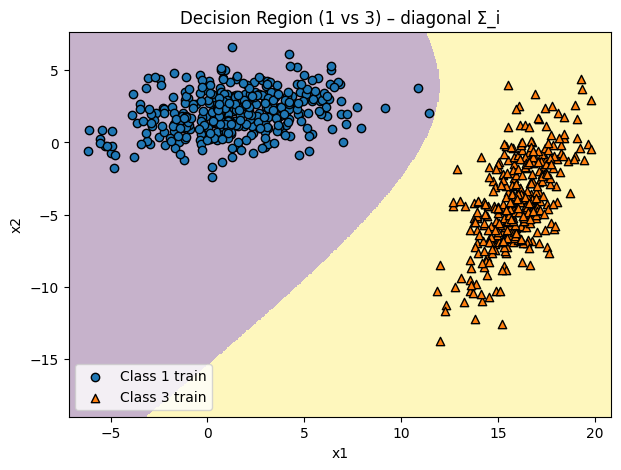

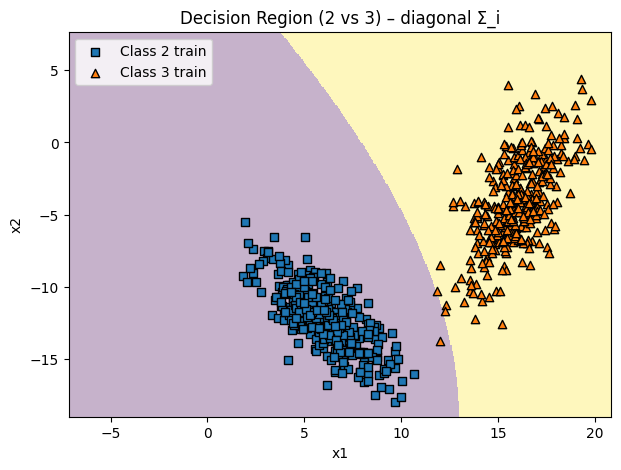

In [28]:
# Cell 28 – Pairwise Decision Regions (Diagonal Σᵢ)

pairs = [(1,2), (1,3), (2,3)]

def predict_pair_diagSigma(X, a, b):
    X = np.atleast_2d(X)
    logpost = np.full((X.shape[0], 2), -np.inf)
    prior_sum = priors[a] + priors[b]
    for i, k in enumerate([a,b]):
        log_lik = log_mvnpdf_general(X, means[k], cov_diag_per_class[k])
        log_prior = np.log(priors[k] / prior_sum)
        logpost[:, i] = log_lik + log_prior
    preds = np.array([a,b])[np.argmax(logpost, axis=1)]
    return preds

for a,b in pairs:
    Z_pair = predict_pair_diagSigma(grid_points, a, b).reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z_pair, shading='auto', alpha=0.3)
    plt.scatter(train_data[a][:,0], train_data[a][:,1], label=f"Class {a} train",
                marker=markers[a], edgecolor='k')
    plt.scatter(train_data[b][:,0], train_data[b][:,1], label=f"Class {b} train",
                marker=markers[b], edgecolor='k')
    plt.title(f"Decision Region ({a} vs {b}) – diagonal Σ_i")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()


## Inference for Diagonal Σᵢ

In [29]:
# Cell 29 – Inference for Diagonal Σᵢ

# Evaluate test accuracy
y_pred_diag = predict_diagSigma(X_test)
cm_diag = confusion_matrix(y_test, y_pred_diag, labels=[1,2,3])
acc_diag = np.trace(cm_diag) / np.sum(cm_diag)

print("Confusion Matrix (diagonal Σ_i):")
print(cm_diag)
print("\nAccuracy:", acc_diag)

print("\nInference for diagonal Σ_i:")
if acc_diag > 0.95:
    print("- Accuracy is very high, suggesting diagonal covariances capture enough structure.")
else:
    print("- Accuracy is lower than full Σ, meaning ignoring correlations harms performance.")

print("- Decision boundaries are linear but not symmetric like σ² I; "
      "they stretch differently along feature axes because of per-class variances.")
print("- This reflects that each class may have different spreads along x1 and x2, "
      "but correlations between dimensions are ignored.")


Confusion Matrix (diagonal Σ_i):
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]

Accuracy: 1.0

Inference for diagonal Σ_i:
- Accuracy is very high, suggesting diagonal covariances capture enough structure.
- Decision boundaries are linear but not symmetric like σ² I; they stretch differently along feature axes because of per-class variances.
- This reflects that each class may have different spreads along x1 and x2, but correlations between dimensions are ignored.


## Contour Plot (Per-Class Diagonal Σᵢ)

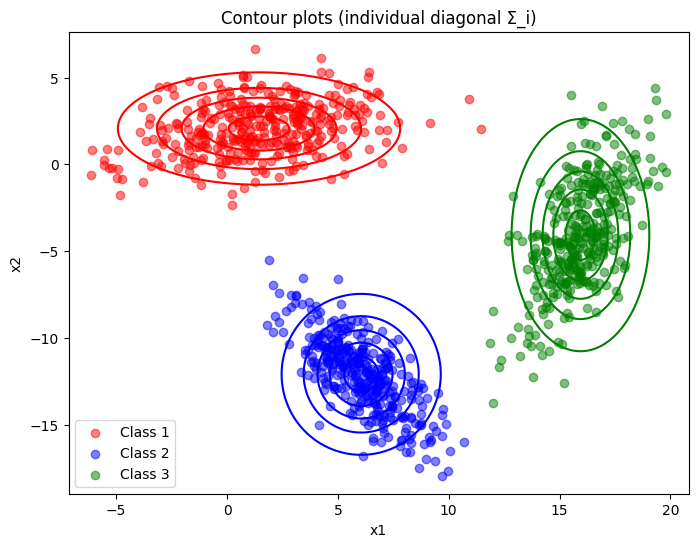

In [30]:
# Cell 30 – Contour Plot (Per-Class Diagonal Σᵢ)

# Contour plot using diagonal Σ_i for each class
levels = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(8,6))
colors = {1:"red", 2:"blue", 3:"green"}

for k in means:
    mu = means[k]
    Sigma_diag = cov_diag_per_class[k]

    logpdf = log_mvnpdf_general(grid_points, mu, Sigma_diag)
    pdf = np.exp(logpdf - np.max(logpdf))
    ZZ = pdf.reshape(xx.shape)

    plt.contour(xx, yy, ZZ, levels=levels, colors=colors[k])
    plt.scatter(train_data[k][:,0], train_data[k][:,1], c=colors[k], alpha=0.5, label=f"Class {k}")

plt.title("Contour plots (individual diagonal Σ_i)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


##  Contour Plots (Diagonal Σᵢ vs Shared Σ)

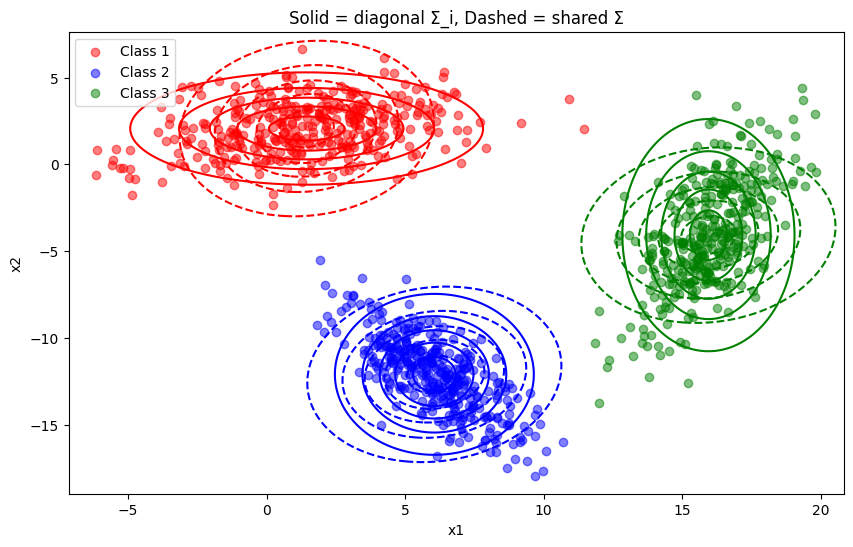

In [31]:
'''

Cell 31 – Contour Plots (Diagonal Σᵢ vs Shared Σ)

Solid = per-class diagonal Σᵢ, Dashed = shared Σ for comparison.

'''

plt.figure(figsize=(10,6))

for k in means:
    mu = means[k]

    # Diagonal Σ_i
    logpdf_diag = log_mvnpdf_general(grid_points, mu, cov_diag_per_class[k])
    pdf_diag = np.exp(logpdf_diag - np.max(logpdf_diag))
    ZZ_diag = pdf_diag.reshape(xx.shape)

    # Shared Σ
    logpdf_shared = log_mvnpdf_general(grid_points, mu, Sigma_common)
    pdf_shared = np.exp(logpdf_shared - np.max(logpdf_shared))
    ZZ_shared = pdf_shared.reshape(xx.shape)

    # Plot both
    plt.contour(xx, yy, ZZ_diag, levels=levels, colors=colors[k], linestyles="solid")
    plt.contour(xx, yy, ZZ_shared, levels=levels, colors=colors[k], linestyles="dashed")

    plt.scatter(train_data[k][:,0], train_data[k][:,1], c=colors[k], alpha=0.5, label=f"Class {k}")

plt.title("Solid = diagonal Σ_i, Dashed = shared Σ")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


##  Print Diagonal Covariance Matrices

In [32]:
# Cell 32 – Print Diagonal Covariance Matrices

print("Diagonal covariance matrices Σ_i (per class):")
for k, covd in cov_diag_per_class.items():
    print(f"\nClass {k} Σ_i:\n{covd}")


Diagonal covariance matrices Σ_i (per class):

Class 1 Σ_i:
[[8.80157416 0.        ]
 [0.         2.27040313]]

Class 2 Σ_i:
[[2.79758295 0.        ]
 [0.         4.65994096]]

Class 3 Σ_i:
[[2.09518912 0.        ]
 [0.         9.7006068 ]]


## Predictor with Full Per-Class Σᵢ

In [33]:
# Cell 33 – Predictor with Full Per-Class Σᵢ

def predict_fullSigma(X):
    X = np.atleast_2d(X)
    logpost = np.full((X.shape[0], n_classes), -np.inf)
    for i, k in enumerate(sorted(means.keys())):
        log_lik = log_mvnpdf_general(X, means[k], cov_per_class[k])  # full covariance Σ_i
        logpost[:, i] = log_lik + np.log(priors[k])
    preds_idx = np.argmax(logpost, axis=1)
    return np.array([sorted(means.keys())[i] for i in preds_idx])


## Decision Regions (All Classes, Full Σᵢ)

C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


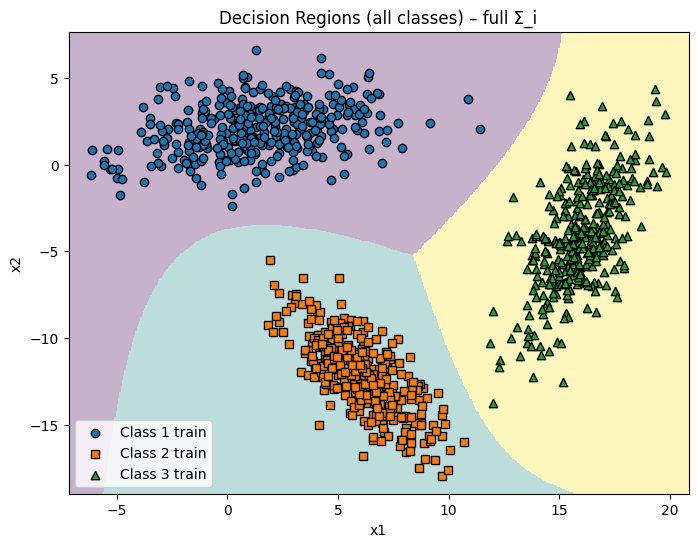

In [34]:
# Cell 34 – Decision Regions (All Classes, Full Σᵢ)

Z_all_full = predict_fullSigma(grid_points).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.pcolormesh(xx, yy, Z_all_full, shading='auto', alpha=0.3)

for k in sorted(train_data.keys()):
    plt.scatter(train_data[k][:,0], train_data[k][:,1],
                label=f"Class {k} train", marker=markers[k], edgecolor='k')

plt.title("Decision Regions (all classes) – full Σ_i")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


## Pairwise Decision Regions (Full Σᵢ)

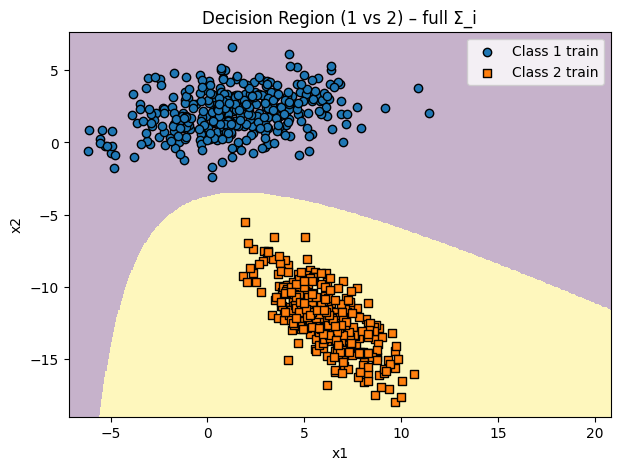

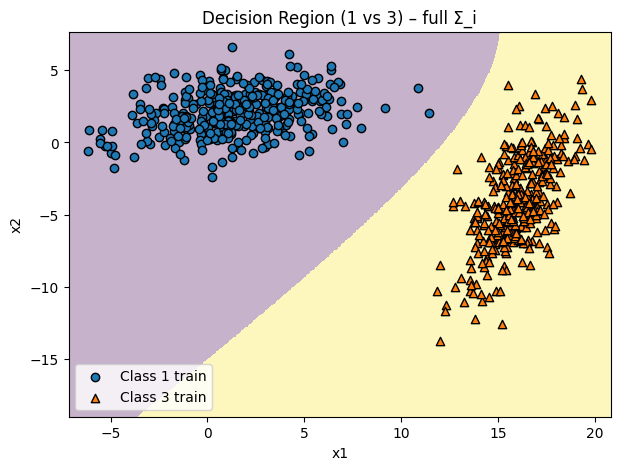

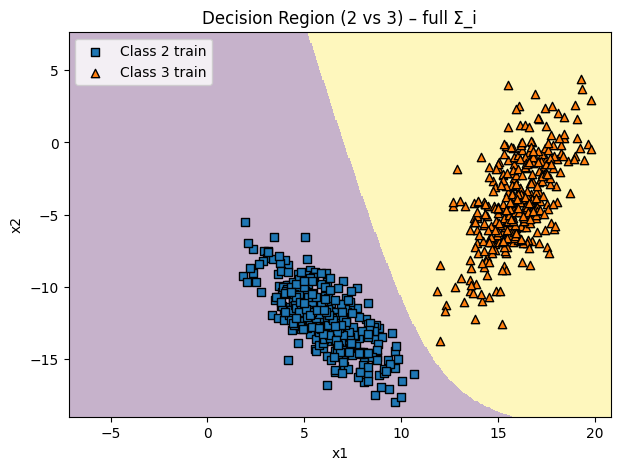

In [35]:
# Cell 35 – Pairwise Decision Regions (Full Σᵢ)

pairs = [(1,2), (1,3), (2,3)]

def predict_pair_fullSigma(X, a, b):
    X = np.atleast_2d(X)
    logpost = np.full((X.shape[0], 2), -np.inf)
    prior_sum = priors[a] + priors[b]
    for i, k in enumerate([a,b]):
        log_lik = log_mvnpdf_general(X, means[k], cov_per_class[k])
        log_prior = np.log(priors[k] / prior_sum)
        logpost[:, i] = log_lik + log_prior
    preds = np.array([a,b])[np.argmax(logpost, axis=1)]
    return preds

for a,b in pairs:
    Z_pair = predict_pair_fullSigma(grid_points, a, b).reshape(xx.shape)
    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, Z_pair, shading='auto', alpha=0.3)
    plt.scatter(train_data[a][:,0], train_data[a][:,1], label=f"Class {a} train",
                marker=markers[a], edgecolor='k')
    plt.scatter(train_data[b][:,0], train_data[b][:,1], label=f"Class {b} train",
                marker=markers[b], edgecolor='k')
    plt.title(f"Decision Region ({a} vs {b}) – full Σ_i")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()


## Confusion Matrix & Accuracy (Full Σᵢ)

In [36]:
# Cell 36 – Confusion Matrix & Accuracy (Full Σᵢ)

# Evaluate test accuracy
y_pred_full = predict_fullSigma(X_test)
cm_full = confusion_matrix(y_test, y_pred_full, labels=[1,2,3])
acc_full = np.trace(cm_full) / np.sum(cm_full)

print("Confusion Matrix (full Σ_i):")
print(cm_full)
print("\nAccuracy:", acc_full)

# Per-class metrics
precision, recall, f1 = [], [], []
for i in range(3):
    tp = cm_full[i,i]
    fp = cm_full[:,i].sum() - tp
    fn = cm_full[i,:].sum() - tp
    prec = tp/(tp+fp) if (tp+fp)>0 else 0
    rec = tp/(tp+fn) if (tp+fn)>0 else 0
    f = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0
    precision.append(prec)
    recall.append(rec)
    f1.append(f)

print("\nPer-Class Metrics (full Σ_i):")
for i in range(3):
    print(f"Class {i+1}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

print("\nMean Precision:", np.mean(precision))
print("Mean Recall:", np.mean(recall))
print("Mean F1:", np.mean(f1))


Confusion Matrix (full Σ_i):
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]

Accuracy: 1.0

Per-Class Metrics (full Σ_i):
Class 1: Precision=1.000, Recall=1.000, F1=1.000
Class 2: Precision=1.000, Recall=1.000, F1=1.000
Class 3: Precision=1.000, Recall=1.000, F1=1.000

Mean Precision: 1.0
Mean Recall: 1.0
Mean F1: 1.0


## Contour Plot (Per-Class Full Σᵢ)

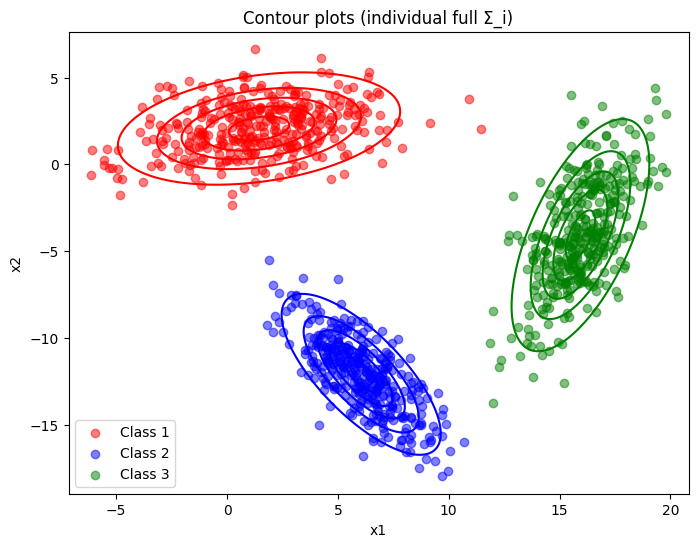

In [37]:
# Cell 37 – Contour Plot (Per-Class Full Σᵢ)

# Contour plots with individual full covariance Σ_i for each class
levels = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(8,6))
colors = {1:"red", 2:"blue", 3:"green"}

for k in means:
    mu = means[k]
    Sigma_full = cov_per_class[k]

    logpdf = log_mvnpdf_general(grid_points, mu, Sigma_full)
    pdf = np.exp(logpdf - np.max(logpdf))
    ZZ = pdf.reshape(xx.shape)

    plt.contour(xx, yy, ZZ, levels=levels, colors=colors[k])
    plt.scatter(train_data[k][:,0], train_data[k][:,1], c=colors[k], alpha=0.5, label=f"Class {k}")

plt.title("Contour plots (individual full Σ_i)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


## Contour Plots (Full Σᵢ vs Shared Σ)

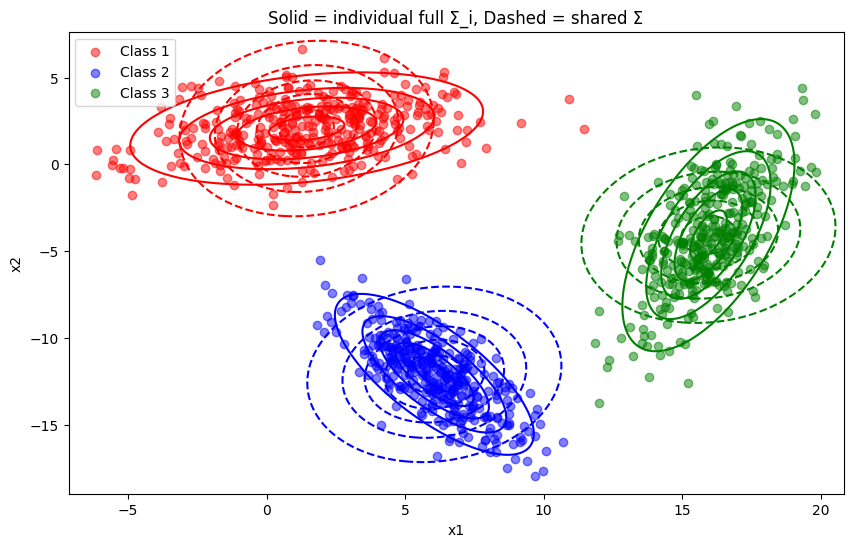

In [38]:
'''

Cell 38 – Contour Plots (Full Σᵢ vs Shared Σ)

Solid = per-class full Σᵢ, Dashed = shared Σ for comparison.

'''

plt.figure(figsize=(10,6))

for k in means:
    mu = means[k]

    # Per-class full covariance Σ_i
    logpdf_full = log_mvnpdf_general(grid_points, mu, cov_per_class[k])
    pdf_full = np.exp(logpdf_full - np.max(logpdf_full))
    ZZ_full = pdf_full.reshape(xx.shape)

    # Shared Σ (same for all classes)
    logpdf_shared = log_mvnpdf_general(grid_points, mu, Sigma_common)
    pdf_shared = np.exp(logpdf_shared - np.max(logpdf_shared))
    ZZ_shared = pdf_shared.reshape(xx.shape)

    # Plot contours
    plt.contour(xx, yy, ZZ_full, levels=levels, colors=colors[k], linestyles="solid")
    plt.contour(xx, yy, ZZ_shared, levels=levels, colors=colors[k], linestyles="dashed")

    plt.scatter(train_data[k][:,0], train_data[k][:,1], c=colors[k], alpha=0.5, label=f"Class {k}")

plt.title("Solid = individual full Σ_i, Dashed = shared Σ")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()



## Print Covariance Matrices

In [39]:
# Cell 39 – Print Covariance Matrices

print("Individual full covariance matrices Σ_i (per class):")
for k, cov in cov_per_class.items():
    print(f"\nClass {k} Σ_i:\n{cov}")

print("\nShared covariance matrix Σ (average of per-class covariances):")
print(Sigma_common)


Individual full covariance matrices Σ_i (per class):

Class 1 Σ_i:
[[8.80157416 1.35490333]
 [1.35490333 2.27040313]]

Class 2 Σ_i:
[[ 2.79758295 -2.66056384]
 [-2.66056384  4.65994096]]

Class 3 Σ_i:
[[2.09518912 2.76726304]
 [2.76726304 9.7006068 ]]

Shared covariance matrix Σ (average of per-class covariances):
[[4.56478207 0.48720084]
 [0.48720084 5.5436503 ]]


## Prior Probability Distributions

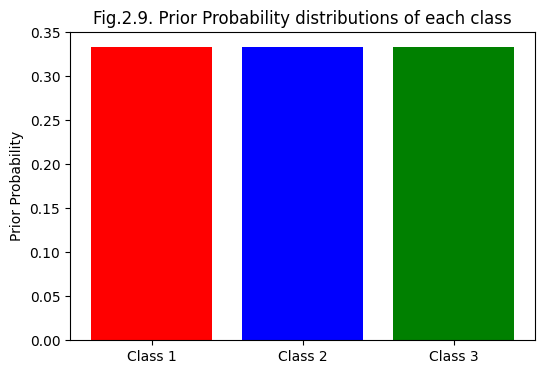

Prior probabilities: {1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333}


In [40]:
# Cell 40 – Prior Probability Distributions (Fig. 2.9)

# Plot prior probabilities as a bar chart
plt.figure(figsize=(6,4))
plt.bar(priors.keys(), priors.values(), color=["red","blue","green"])
plt.xticks([1,2,3], ["Class 1","Class 2","Class 3"])
plt.ylabel("Prior Probability")
plt.title("Fig.2.9. Prior Probability distributions of each class")
plt.show()

print("Prior probabilities:", priors)


##  Confusion Matrices for All Four Cases

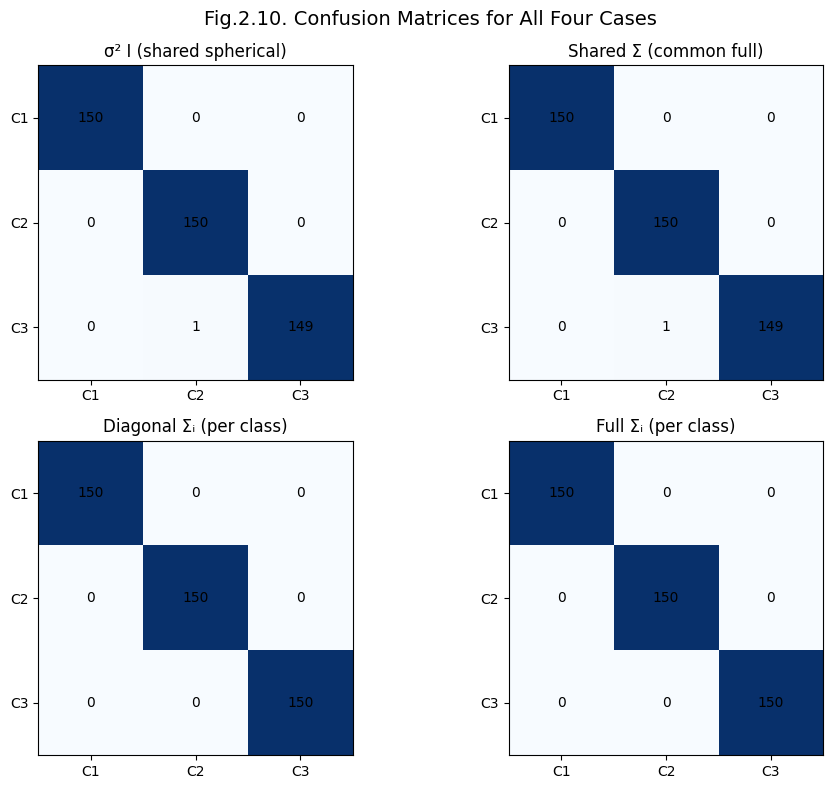

In [46]:
# Cell 41 – Confusion Matrices for All Four Cases (Fig. 2.10)

# Collect confusion matrices
cm_sigma2I = confusion_matrix(y_test, predict_sigma2I(X_test), labels=[1,2,3])
cm_common  = confusion_matrix(y_test, predict_commonSigma(X_test), labels=[1,2,3])
cm_diag    = confusion_matrix(y_test, predict_diagSigma(X_test), labels=[1,2,3])
cm_full    = confusion_matrix(y_test, predict_fullSigma(X_test), labels=[1,2,3])

cms = {
    "σ² I (shared spherical)": cm_sigma2I,
    "Shared Σ (common full)": cm_common,
    "Diagonal Σᵢ (per class)": cm_diag,
    "Full Σᵢ (per class)": cm_full,
}

# Plot them side by side
fig, axes = plt.subplots(2,2, figsize=(10,8))
for ax,(title,cm) in zip(axes.ravel(), cms.items()):
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0,1,2]); ax.set_xticklabels(["C1","C2","C3"])
    ax.set_yticks([0,1,2]); ax.set_yticklabels(["C1","C2","C3"])
    for i in range(3):
        for j in range(3):
            ax.text(j,i,cm[i,j],ha="center",va="center",color="black")
        # fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle("Fig.2.10. Confusion Matrices for All Four Cases", fontsize=14)
plt.tight_layout()
plt.show()


## Classification Metrics Comparison 

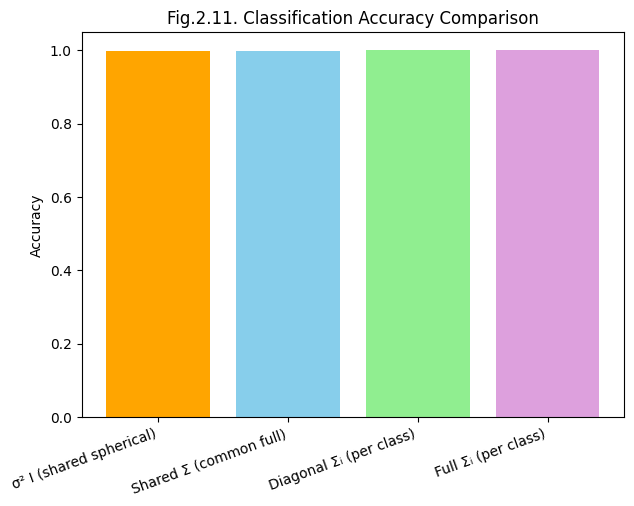

Classification Accuracies:
σ² I (shared spherical): 0.998
Shared Σ (common full): 0.998
Diagonal Σᵢ (per class): 1.000
Full Σᵢ (per class): 1.000


In [42]:
# Cell 42 – Classification Metrics Comparison (Fig. 2.11)

# Helper to compute accuracy
def get_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3])
    acc = np.trace(cm)/np.sum(cm)
    return acc

# Compute accuracies
acc_sigma2I = get_metrics(y_test, predict_sigma2I(X_test))
acc_common  = get_metrics(y_test, predict_commonSigma(X_test))
acc_diag    = get_metrics(y_test, predict_diagSigma(X_test))
acc_full    = get_metrics(y_test, predict_fullSigma(X_test))

# Collect into dict
accs = {
    "σ² I (shared spherical)": acc_sigma2I,
    "Shared Σ (common full)": acc_common,
    "Diagonal Σᵢ (per class)": acc_diag,
    "Full Σᵢ (per class)": acc_full,
}

# Plot as bar chart
plt.figure(figsize=(7,5))
plt.bar(accs.keys(), accs.values(), color=["orange","skyblue","lightgreen","plum"])
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.xticks(rotation=20, ha="right")
plt.title("Fig.2.11. Classification Accuracy Comparison")
plt.show()

print("Classification Accuracies:")
for k,v in accs.items():
    print(f"{k}: {v:.3f}")
